# Pitchnet DEMO Notebook

This notebook:
1. Demonstrates how to evauate the pre-trained pitch network models on new stimuli
2. Provides a sample SLURM `sbatch` script for training new pich network models
3. Provides a sample SLURM `sbatch` script for evaluating networks on psychophysical experiment stimuli
4. Provides a sample SLURM `sbatch` script for running psychophysical experiments and plotting results

To run this notebook within the provided Singularity environment:
1. `$ PITCHNET_PATH=$(pwd)`
2. `$ singularity exec --nv -B $PITCHNET_PATH -B $PITCHNET_PATH/packages:/packages tensorflow-1.13.1-pitchnet.simg jupyter notebook`

NOTE: The `bez2018model` Python auditory nerve model wrapper must be installed within the Singularity environment:
1. `cd /packages/bez2018model`
2. `python setup.py build_ext --inplace`


## 1. Evaluating pre-trained pitch network models on new stimuli

In [1]:
import os
import sys
import json
import time
import IPython.display as ipd
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

# Import functions for generating figures and audio stimuli
sys.path.append('/packages/msutil/')
import util_figures
import util_stimuli

# Import Python wrapper for Bruce et al. (2018) auditory nerve model
sys.path.append('/packages/bez2018model/')
import bez2018model

# Import functions for deep neural network models
sys.path.append('/packages/tfutil/')
import functions_brain_network
import functions_graph_assembly

# Import F0 classification bin functions from dataset_util
sys.path.append('./assets_datasets/')
from dataset_util import get_f0_bins, f0_to_label, label_to_f0


### Generate sound waveform

Generate audio waveform to test model(s) on. Default settings create a sine-phase harmonic complex tone with 200 Hz F0 (150 ms duration and 32 kHz sampling rate). The tone is embedded in modified uniform masking noise (0 dB SNR) and the stimulus is re-scaled to 60 dB SPL.


In [2]:
np.random.seed(0)

signal_fs = 32000
signal = util_stimuli.complex_tone(
    f0=200,
    fs=signal_fs,
    dur=0.150,
    harmonic_numbers=np.arange(1, 31),
    frequencies=None,
    amplitudes=None,
    phase_mode='sine',
    offset_start=True,
    strict_nyquist=True)
noise = util_stimuli.modified_uniform_masking_noise(
    fs=signal_fs,
    dur=0.150,
    dBHzSPL=15.0,
    attenuation_start=600.0,
    attenuation_slope=2.0)
signal = util_stimuli.combine_signal_and_noise(signal, noise, snr=0.0)
signal = util_stimuli.set_dBSPL(signal, 60.0)

ipd.display(ipd.Audio(signal, rate=signal_fs))


### Generate simulated auditory nerve representation

Default parameters correspond to the standard auditory nerve model (most human-like). 


In [3]:
kwargs_nervegram = {
    'nervegram_dur': 0.050, # auditory nerve representation is clipped to 50 ms
    'nervegram_fs': 20e3, # auditory nerve representation is sampled at 20 kHz
    'buffer_start_dur': 0.070,
    'buffer_end_dur': 0.010,
    'pin_fs': 100e3,
    'pin_dBSPL_flag': 0,
    'pin_dBSPL': None,
    'species': 2,
    'bandwidth_scale_factor': 1.0, # scales bandwidths of cochlear filters
    'cf_list': None,
    'num_cf': 100, # simulate 100 auditory nerve fibers with CFs from 125 to 14000 Hz
    'min_cf': 125.0,
    'max_cf': 14e3,
    'synapseMode': 0,
    'max_spikes_per_train': -1,
    'num_spike_trains': 40,
    'cohc': 1.0,
    'cihc': 1.0,
    'IhcLowPass_cutoff': 3e3, # IHC lowpass filter cutoff in Hz (default 3000 Hz)
    'IhcLowPass_order': 7,
    'spont': 70.0,
    'noiseType': 1,
    'implnt': 0,
    'tabs': 6e-4,
    'trel': 6e-4,
    'random_seed': None,
    'return_vihcs': False,
    'return_meanrates': True, # Pitch DNN models expect `meanrates` nervegram input
    'return_spike_times': False,
    'return_spike_tensor_sparse': False,
    'return_spike_tensor_dense': False,
    'nervegram_spike_tensor_fs': 100e3,
    'squeeze_channel_dim': True
}

t0 = time.time()
nervegram_output_dict = bez2018model.nervegram(signal, signal_fs, **kwargs_nervegram)
t1 = time.time()

print("time to generate bez2018model nervegram: {:.2f} seconds".format(t1-t0))
print("bez2018model nervegram shape: {}".format(nervegram_output_dict['nervegram_meanrates'].shape))


time to generate bez2018model nervegram: 10.25 seconds
bez2018model nervegram shape: (100, 1000)


### Visualize simulated auditory nerve representation

The sound waveform is plotted at the top. The stimulus power spectrum (with ERB-scaled frequency axis) is plotted to the left. The grey-scale image plots the array of instantaneous auditory nerve firing rates (i.e., the `nervegram_meanrates`). Lighter colors indicate more spiking. The time-averaged firing rates (the excitation pattern) are plotted to the right.


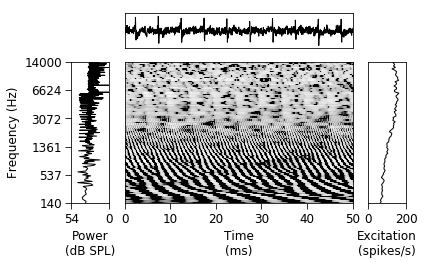

In [4]:
fig, ax_arr = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(6, 3.5),
    gridspec_kw={'wspace': 0.15, 'hspace': 0.15, 'width_ratios': [1,6,1], 'height_ratios': [1,4]})

util_figures.make_stimulus_summary_plot(
    ax_arr,
    ax_idx_waveform=1,
    ax_idx_spectrum=3,
    ax_idx_nervegram=4,
    ax_idx_excitation=5,
    waveform=nervegram_output_dict['signal'],
    nervegram=nervegram_output_dict['nervegram_meanrates'],
    sr_waveform=nervegram_output_dict['signal_fs'],
    sr_nervegram=nervegram_output_dict['nervegram_fs'],
    cfs=nervegram_output_dict['cf_list'],
    tmin=None,
    tmax=None,
    treset=True,
    vmin=None,
    vmax=None,
    erb_freq_axis=True,
    spines_to_hide_waveform=[],
    spines_to_hide_spectrum=[],
    spines_to_hide_excitation=[],
    nxticks=6,
    nyticks=6,
    kwargs_plot={},
    limits_buffer=0.2,
    ax_arr_clear_leftover=True)

plt.show()


### Build pitch model deep neural network(s) and evaluate them on the stimulus.

In [5]:
# Specify list of model directories to run (one directory per network)
# NOTE: To evaluate only one network, simply comment out the other 9
list_dir_model = [
    'models/default/arch_0083',
    'models/default/arch_0154',
    'models/default/arch_0190',
    'models/default/arch_0191',
    'models/default/arch_0286',
    'models/default/arch_0288',
    'models/default/arch_0302',
    'models/default/arch_0335',
    'models/default/arch_0338',
    'models/default/arch_0346',
]
basename_arch = 'brain_arch.json' # Model architecture file within directory
basename_ckpt = 'brain_model.ckpt' # Model checkpoint file within directory

# Construct a tensorflow graph containing all specified networks
tf.reset_default_graph()
tf.get_logger().setLevel('ERROR') # Suppress tensorflow deprecation warnings

# Input nervegrams are provided via a placeholder (networks expect shape [100, 1000])
placeholder_nervegram = tf.placeholder(tf.float32, shape=[100, 1000])
tensor_nervegram = placeholder_nervegram[tf.newaxis, : , :, tf.newaxis]

# Iterate over model directories and build DNN graphs
dict_model_vars = {} # Dictionary of variables for each network
dict_model_softmax = {} # Dictionary of softmax tensors for each network
for dir_model in list_dir_model:
    tensor_logits, tensor_dict = functions_graph_assembly.build_brain_graph(
        tensor_nervegram,
        N_CLASSES_DICT={'f0_label': 700},
        config=os.path.join(dir_model, basename_arch),
        batchnorm_flag=False,
        dropout_flag=True,
        save_pckl_path=None,
        save_arch_path=None,
        trainable=False,
        only_include_layers=None,
        var_scope_name=dir_model,
        var_scope_reuse=False)
    # Collect variables for current network
    var_list =  tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=dir_model)
    dict_model_vars[dir_model] = {
        v.name[:-2].replace(dir_model, 'brain_network'): v for v in var_list
    }
    # Convert current network outputs to F0 class probabilities
    dict_model_softmax[dir_model] = tf.nn.softmax(tensor_logits['f0_label'])


t0 = time.time()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Iterate over model directories and load network weights from checkpoints
    for dir_model in list_dir_model:
        functions_graph_assembly.build_saver(
            sess,
            dict_model_vars[dir_model],
            dir_model,
            restore_model_path=None,
            ckpt_prefix_name=basename_ckpt,
            attempt_load=True)
    t1 = time.time()
    print('time to initialize and load model(s): {:.2f}'.format(t1-t0))
    
    # Evaluate the networks on `nervegram_output_dict['nervegram_meanrates']`
    t0 = time.time()
    feed_dict = {placeholder_nervegram: nervegram_output_dict['nervegram_meanrates']}
    dict_model_softmax_output = sess.run(dict_model_softmax, feed_dict=feed_dict)
    t1 = time.time()
    print('time to run model(s): {:.2f}'.format(t1-t0))
    print('network output shapes (F0 class probabilities)')
    for key in sorted(dict_model_softmax_output.keys()):
        print('|__ {}: {}'.format(key, dict_model_softmax_output[key].shape))


Loading brain network config from models/default/arch_0083/brain_arch.json
Loading brain network config from models/default/arch_0154/brain_arch.json
Loading brain network config from models/default/arch_0190/brain_arch.json
Loading brain network config from models/default/arch_0191/brain_arch.json
Loading brain network config from models/default/arch_0286/brain_arch.json
Loading brain network config from models/default/arch_0288/brain_arch.json
Loading brain network config from models/default/arch_0302/brain_arch.json
Loading brain network config from models/default/arch_0335/brain_arch.json
Loading brain network config from models/default/arch_0338/brain_arch.json
Loading brain network config from models/default/arch_0346/brain_arch.json
### Loading variables from latest checkpoint: models/default/arch_0083/brain_model.ckpt-70000
### Loading variables from latest checkpoint: models/default/arch_0154/brain_model.ckpt-55000
### Loading variables from latest checkpoint: models/default/a

### Convert model output probabilities to F0 estimates

In [7]:
print('network F0 predictions in Hz:')
f0_bins = get_f0_bins()
for key in sorted(dict_model_softmax_output.keys()):
    predicted_labels = np.argmax(dict_model_softmax_output[key], axis=1)
    print('|__ {}: {}'.format(key, label_to_f0(predicted_labels, f0_bins)))


network F0 predictions in Hz:
|__ models/default/arch_0083: [200.13709211]
|__ models/default/arch_0154: [199.41587152]
|__ models/default/arch_0190: [199.41587152]
|__ models/default/arch_0191: [200.86092112]
|__ models/default/arch_0286: [200.13709211]
|__ models/default/arch_0288: [199.41587152]
|__ models/default/arch_0302: [200.13709211]
|__ models/default/arch_0335: [200.86092112]
|__ models/default/arch_0338: [199.41587152]
|__ models/default/arch_0346: [200.13709211]


## 2. Sample SLURM script for training new pitch networks

NOTE: Model training requires simulated auditory nerve representations of the training stimuli.


```
#!/bin/bash
#
#SBATCH --job-name=pitchnet_train
#SBATCH --out="slurm-%A_%a.out"
#SBATCH --cpus-per-task=6
#SBATCH --mem=18000
#SBATCH --gres=gpu:1
#SBATCH --time=0-48:00:00
#SBATCH --array=0-9

#### Specify list of model directories to train and use SLURM_ARRAY_TASK_ID to select one per job
declare -a list_model_dir=(
    '/models/demo_train/arch_0191/',
    '/models/demo_train/arch_0302/',
    '/models/demo_train/arch_0288/',
    '/models/demo_train/arch_0335/',
    '/models/demo_train/arch_0346/',
    '/models/demo_train/arch_0286/',
    '/models/demo_train/arch_0083/',
    '/models/demo_train/arch_0154/',
    '/models/demo_train/arch_0190/',
    '/models/demo_train/arch_0338/',
)
offset=0
job_idx=$(($SLURM_ARRAY_TASK_ID + $offset))
model_dir=${list_model_dir[$job_idx]}

#### Specify paths for training dataset and validation dataset tfrecords
DATA_TRAIN="dataset_pitchnet_train/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/bez2018meanrates_0[0-7]*.tfrecords"
DATA_VALID="dataset_pitchnet_train/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/bez2018meanrates_0[8-9]*.tfrecords"

#### Run training routine within Singularity environment (NOTE: customize paths for -B flags)
singularity exec --nv \
-B /om2/user/$USER/pitchnet/ \
-B /om2/user/$USER/pitchnet/packages:/packages \
-B /om2/user/$USER/pitchnet/models:/models \
tensorflow-1.13.1-pitchnet.simg \
python -u /packages/tfutil/run_train_or_eval.py "$model_dir" \
-dt "$DATA_TRAIN" \
-de "$DATA_VALID" \
-t -e -f
```


## 3. Sample SLURM script for evaluating networks on psychophysical experiment stimuli

NOTE: Model evaluation requires simulated auditory nerve representations of the psychophysical stimuli.


```
#!/bin/bash
#
#SBATCH --job-name=pitchnet_eval
#SBATCH --out="slurm-%A_%a.out"
#SBATCH --cpus-per-task=6
#SBATCH --mem=18000
#SBATCH --gres=gpu:1
#SBATCH --time=0-48:00:00
#SBATCH --array=0-9

#### Specify list of model directories to train and use SLURM_ARRAY_TASK_ID to select one per job
declare -a list_model_dir=(
    '/models/default/arch_0191/',
    '/models/default/arch_0302/',
    '/models/default/arch_0288/',
    '/models/default/arch_0335/',
    '/models/default/arch_0346/',
    '/models/default/arch_0286/',
    '/models/default/arch_0083/',
    '/models/default/arch_0154/',
    '/models/default/arch_0190/',
    '/models/default/arch_0338/',
)
offset=0
job_idx=$(($SLURM_ARRAY_TASK_ID + $offset))
model_dir=${list_model_dir[$job_idx]}

#### Specify path to psychophysical stimulus dataset tfrecords (uncomment one experiment below)
TFRECORDS_PATH="sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/bez2018meanrates*tfrecords"

#### Experiment A (Bernstein and Oxenham, 2005)
DATA_EVAL="data_psychophysics/bernox2005/lowharm_v01/$TFRECORDS_PATH"
EVAL_OUTPUT_FILENAME="EVAL_SOFTMAX_lowharm_v01_bestckpt.json"

#### Experiment B (Shackleton and Carlyon, 1994)
# DATA_EVAL="data_psychophysics/mooremoore2003/freqshifted_v01/$TFRECORDS_PATH"
# EVAL_OUTPUT_FILENAME="EVAL_SOFTMAX_freqshifted_v01_bestckpt.json"

#### Experiment C (Moore and Moore, 2003)
# DATA_EVAL="data_psychophysics/moore1985/mistunedharm_v01/$TFRECORDS_PATH"
# EVAL_OUTPUT_FILENAME="EVAL_SOFTMAX_mistunedharm_v01_bestckpt.json"

#### Experiment D (Moore et al., 1985)
# DATA_EVAL="data_psychophysics/oxenham2004/transposedtones_v01/$TFRECORDS_PATH"
# EVAL_OUTPUT_FILENAME="EVAL_SOFTMAX_transposedtones_v01_bestckpt.json"

#### Experiment E (Oxenham et al., 2004)
# DATA_EVAL="data_psychophysics/shackcarl1994/altphase_v01/$TFRECORDS_PATH"
# EVAL_OUTPUT_FILENAME="EVAL_SOFTMAX_altphase_v01_bestckpt.json"

#### Run evaluation routine within Singularity environment (NOTE: customize paths for -B flags)
singularity exec --nv \
-B /om2/user/$USER/pitchnet/ \
-B /om2/user/$USER/pitchnet/packages:/packages \
-B /om2/user/$USER/pitchnet/models:/models \
tensorflow-1.13.1-pitchnet.simg \
python pitchnet_evaluate_best.py \
-de "$DATA_EVAL" \
-efn "$EVAL_OUTPUT_FILENAME" \
-o "$model_dir" \
-wpo 1
```


## 4. Sample SLURM script for simulating psychophysical experiments

Once network predictions for all of the psychophysical stimulus datasets have been stored, this script can be used to simulate the actual psychophysical experiments (e.g., measure discrimination thresholds or shifts in the perceived pitch).


```
#!/bin/bash
#
#SBATCH --job-name=pitchnet_analyze
#SBATCH --out="slurm-%A_%a.out"
#SBATCH --cpus-per-task=6
#SBATCH --mem=36000
#SBATCH --time=0-6:00:00
#SBATCH --array=0-9

#### Specify regular expression that captures all model directories
MODEL_DIR_REGEX="/models/default/arch_????"

#### Specify prior to impose when computing pitch estimates (+/- 0.5 octaves of experiment-specific value)
PRIOR_RANGE="0.5"

#### Run each experiment in the Singularity environment (NOTE: customize paths for -B flags)

#### Experiment A (Bernstein and Oxenham, 2005)
singularity exec \
-B /om2/user/$USER/pitchnet/ \
-B /om2/user/$USER/pitchnet/packages:/packages \
-B /om2/user/$USER/pitchnet/models:/models \
tensorflow-1.13.1-pitchnet.simg \
python assets_psychophysics/f0dl_bernox.py \
-r "${MODEL_DIR_REGEX}/EVAL_SOFTMAX_lowharm_v01_bestckpt.json" \
-p ${PRIOR_RANGE} \
-j ${job_idx}

#### Experiment B (Shackleton and Carlyon, 1994)
singularity exec \
-B /om2/user/$USER/pitchnet/ \
-B /om2/user/$USER/pitchnet/packages:/packages \
-B /om2/user/$USER/pitchnet/models:/models \
tensorflow-1.13.1-pitchnet.simg \
python assets_psychophysics/f0experiment_alt_phase.py \
-r "${MODEL_DIR_REGEX}/EVAL_SOFTMAX_altphase_v01_bestckpt.json" \
-p ${PRIOR_RANGE} \
-j ${job_idx}

#### Experiment C (Moore and Moore, 2003)
singularity exec \
-B /om2/user/$USER/pitchnet/ \
-B /om2/user/$USER/pitchnet/packages:/packages \
-B /om2/user/$USER/pitchnet/models:/models \
tensorflow-1.13.1-pitchnet.simg \
python assets_psychophysics/f0experiment_freq_shifted.py \
-r "${MODEL_DIR_REGEX}/EVAL_SOFTMAX_freqshifted_v01_bestckpt.json" \
-p ${PRIOR_RANGE} \
-j ${job_idx}

#### Experiment D (Moore et al., 1985)
singularity exec \
-B /om2/user/$USER/pitchnet/ \
-B /om2/user/$USER/pitchnet/packages:/packages \
-B /om2/user/$USER/pitchnet/models:/models \
tensorflow-1.13.1-pitchnet.simg \
python assets_psychophysics/f0experiment_mistuned_harmonics.py \
-r "${MODEL_DIR_REGEX}/EVAL_SOFTMAX_mistunedharm_v01_bestckpt.json" \
-p ${PRIOR_RANGE} \
-j ${job_idx}

#### Experiment E (Oxenham et al., 2004)
singularity exec \
-B /om2/user/$USER/pitchnet/ \
-B /om2/user/$USER/pitchnet/packages:/packages \
-B /om2/user/$USER/pitchnet/models:/models \
tensorflow-1.13.1-pitchnet.simg \
python assets_psychophysics/f0dl_transposed_tones.py \
-r "${MODEL_DIR_REGEX}/EVAL_SOFTMAX_transposedtones_v01_bestckpt.json" \
-p ${PRIOR_RANGE} \
-j ${job_idx}
```
